In [17]:
import pandas as pd
import pandahouse as ph
import seaborn as sns
from scipy import stats

In [3]:
connection = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database':'simulator_20230120',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }


In [13]:
q = """
SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM {db}.feed_actions 
WHERE toDate(time) between '2022-12-25' and '2022-12-31'
    and exp_group in (2,3)
GROUP BY exp_group, user_id
"""

df = ph.read_clickhouse(q, connection=connection)

df.groupby('exp_group').count()

,user_id,likes,views,ctr
exp_group,,,,
2,8480,8480,8480,8480
3,8569,8569,8569,8569


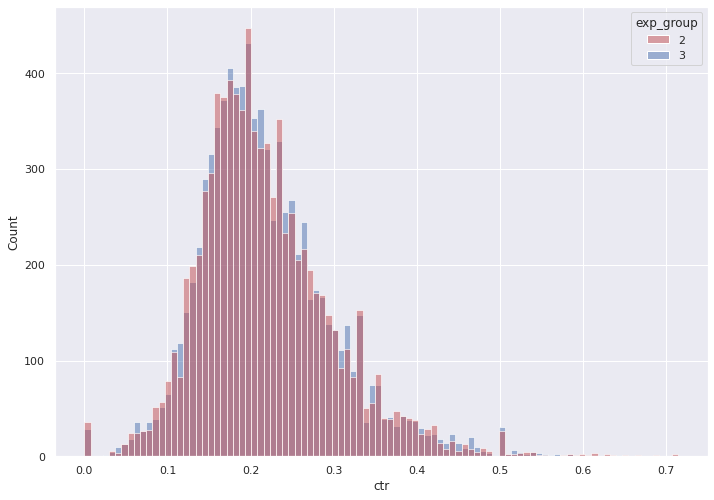

In [14]:
# Сделаем графики в seaborn покрупнее
sns.set(rc={'figure.figsize':(11.7,8.27)})

groups = sns.histplot(data = df, 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

## Задание
Данные АА-теста с **'2022-12-25' по '2022-12-31'**. 
Нужно сделать симуляцию, как будто мы провели 10000 АА-тестов. На каждой итерации вам нужно сформировать подвыборки без повторения в 500 юзеров из **2 и 3** экспериментальной группы. Провести сравнение этих подвыборок t-testом.

1. Построить гистограмму распределения получившихся 10000 p-values.

2. Посчитать, какой процент p values оказался меньше либо равен 0.05

3. Написать вывод по проведенному АА-тесту, корректно ли работает наша система сплитования.

In [34]:
alpha = 0.05
n_tests = 10000

In [37]:
p_value = []
cnt = 0
for i in range(n_tests):
    data = df.groupby('exp_group').sample(n=500)
    
    #T-тест
    p = stats.ttest_ind(data[data.exp_group == 2].ctr,
                    data[data.exp_group == 3].ctr,
                    equal_var=False).pvalue
    p_value.append(p)
    if p<=alpha:
        cnt +=1

### 1. Гистограмма распределения p-value

<AxesSubplot:ylabel='Count'>

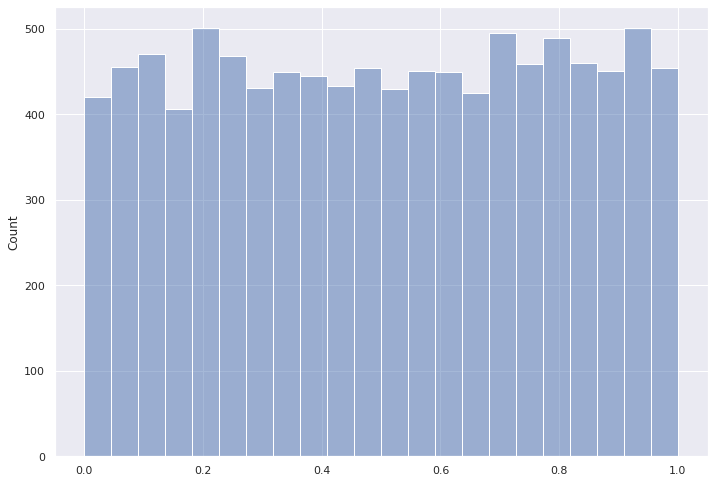

In [38]:
sns.histplot(data = p_value, 
              alpha=0.5,
              kde=False)

### 2.Процент p-value меньше или равен 0.05

In [39]:
percent = round(cnt*100/n_tests,2)
print(f'В проведенной серии АА-тестов только в {percent}% случаев отвергали нулевую гипотезу. Данное значение близко к 5%')

В проведенной серии АА-тестов только в 4.7% случаев отвергали нулевую гипотезу. Данное значение близко к 5%


### 3.Вывод по АА-тесту

За неимением возможности проводить 10к АА-тестов мы сделали их симуляцию за счет подвыборок. 
Целью данного действия была проверка:
1. Убедиться, что группы одинаковы в рамкам метрики ctr.
2. Убедиться, что наша система сплитирования работает верно и процент срабатываний t-теста равен уровню альфа (приблизительно равен).

После проведения симуляции была построена гистограмма распределения p-value: как можно видеть распределено оно равномерно, т.к. группы неотличимы и p-value равновероятно принимает любое значение. При этом значения <=0.05 оно принимает только в ~5% случаев, а значит т-тест правильно работает на данном наборе данных.